In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# import seaborn as sns
# sns.set()

## Background and problem statement
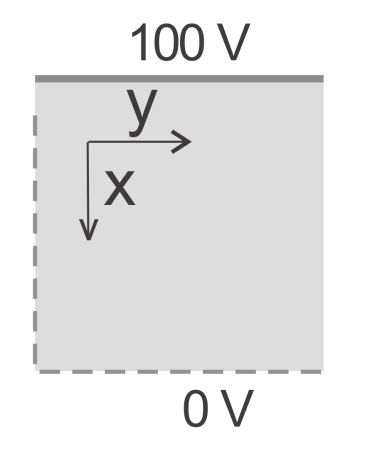

Assume we have a conducting medium with uniform constant conductivity. With given boundary conditions (potential on the border of the medium) we will recover full distribution of the potential in the medium.

System of interest is presented in the picture. Upper side of the square has 100V potential, while all other sides have 0V potential. 

The equation, describing correct V function is
$$\Delta V(\vec{r}) = -\frac{\rho(\vec{r})}{\varepsilon_0}$$

In out case there are no free charges inside the medium, i.e. $\rho=0$

Distribution will be computed with three different algorithms, namely i) the Jacobi, ii) the Gauss-Jacobi and
iii) the SOR


# Simulation

In [3]:
def generate_map(L, mode="target"):
    """

    generates initial potential distribution and marks which points have defined potential

    Args:
        L (int): greed side
        mode (str, optional): type of distribution to generate. Defaults to "target".
    Returns:
        np.array: (l+2)x(l+2) array with potential values
        np.array: (l+2)x(l+2) mask array. 1-free potential, 0-fixed
    """
    potential = np.zeros((L+2, L+2))
    mask = np.ones_like(potential, dtype=bool)
    if mode == "target":
        potential[0] = 100

        mask[[0, -1]] = 0
        mask[:, [0, -1]] = 0

    elif mode == "test":
        potential[0] = 100

        mask[[0, -1]] = 0

    return potential, mask

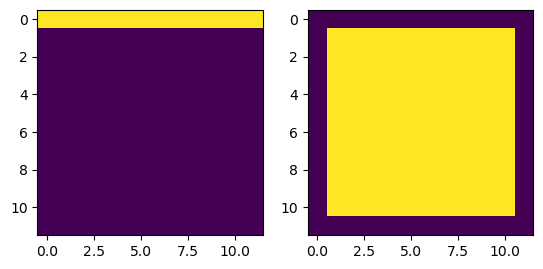

In [4]:

potential, mask = generate_map(10)
plt.subplot(1, 2, 1)
plt.imshow(potential)
plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.show()

## Integration methods

In [5]:
def jacobi_optimize(potential: np.ndarray, mask: np.ndarray, max_steps):
    history = [potential]
    for _ in range(max_steps):
        prev = history[-1]
        new = np.zeros_like(prev)
        for i in range(prev.shape[0]):
            for j in range(prev.shape[1]):
                if mask[i, j]: # update potential
                    values_near = []
                    for i_, j_ in [(i+1, j), (i, j+1), (i-1, j), (i, j-1)]:
                        if 0 <= i_ < prev.shape[0] and 0 <= j_ < prev.shape[1]:
                            values_near.append(prev[i_, j_])
                    new[i, j] = np.mean(values_near)
                else:   # fixed potential
                    new[i, j] = prev[i, j]
        history.append(new)

    return history

def gauss_optimize(potential: np.ndarray, mask: np.ndarray, max_steps):
    history = [potential]
    for _ in range(max_steps):
        prev = history[-1]
        new = np.zeros_like(prev)
        for i in range(prev.shape[0]):
            for j in range(prev.shape[1]):
                if mask[i, j]: # update potential
                    values_near = []
                    for i_, j_ in [(i-1, j), (i, j-1)]: # take updated values from updated dist
                        if 0 <= i_ < prev.shape[0] and 0 <= j_ < prev.shape[1]:
                            values_near.append(new[i_, j_])
                    for i_, j_ in [(i+1, j), (i, j+1)]: # not updated values from previous step
                        if 0 <= i_ < prev.shape[0] and 0 <= j_ < prev.shape[1]:
                            values_near.append(prev[i_, j_])
                    new[i, j] = np.mean(values_near)
                else:   # fixed potential
                    new[i, j] = prev[i, j]
        history.append(new)

    return history


def SOR_optimize(potential: np.ndarray, mask: np.ndarray, max_steps, w=None):
    if w is None:
        w = 2/(1+np.pi/potential.shape[0])

    history = [potential]
    for _ in range(max_steps):
        prev = history[-1]
        new = np.zeros_like(prev)
        for i in range(prev.shape[0]):
            for j in range(prev.shape[1]):
                if mask[i, j]: # update potential
                    values_near = []
                    for i_, j_ in [(i-1, j), (i, j-1)]: # take updated values from updated dist
                        if 0 <= i_ < prev.shape[0] and 0 <= j_ < prev.shape[1]:
                            values_near.append(new[i_, j_])
                    for i_, j_ in [(i+1, j), (i, j+1)]: # not updated values from previous step
                        if 0 <= i_ < prev.shape[0] and 0 <= j_ < prev.shape[1]:
                            values_near.append(prev[i_, j_])

                    new[i, j] = w*np.mean(values_near) + (1-w)*prev[i, j]
                else:   # fixed potential
                    new[i, j] = prev[i, j]
        history.append(new)

    return history

#### Testing

With fixed potential only for vertical sides we would expect constant vertical electric field, so constant gradient of the potential

In [6]:
def get_theory_solution(L):
    v = np.linspace(100, 0, L+2)
    result = np.ones((L+2, L+2))*v.reshape(-1, 1)
    return result
get_theory_solution(3)

array([[100., 100., 100., 100., 100.],
       [ 75.,  75.,  75.,  75.,  75.],
       [ 50.,  50.,  50.,  50.,  50.],
       [ 25.,  25.,  25.,  25.,  25.],
       [  0.,   0.,   0.,   0.,   0.]])

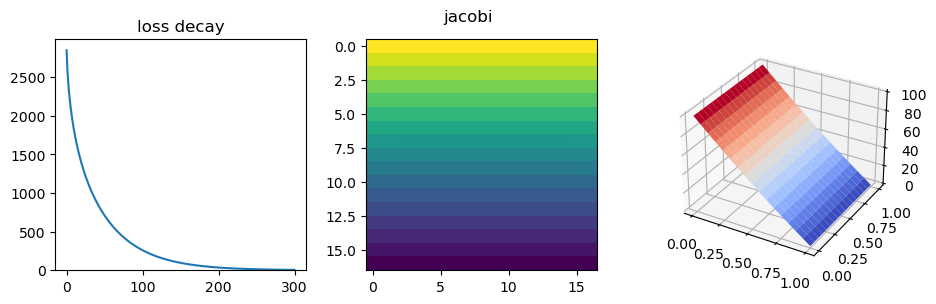

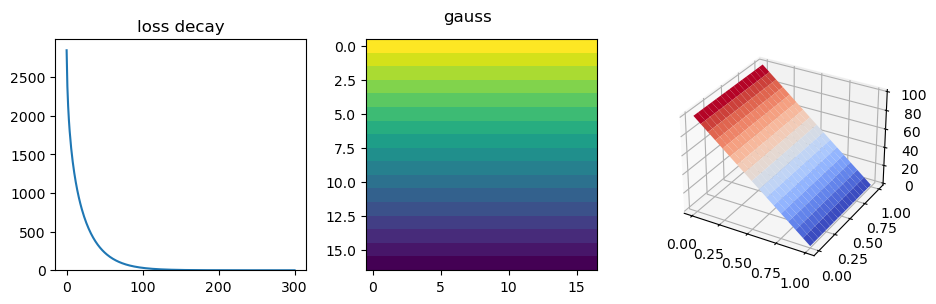

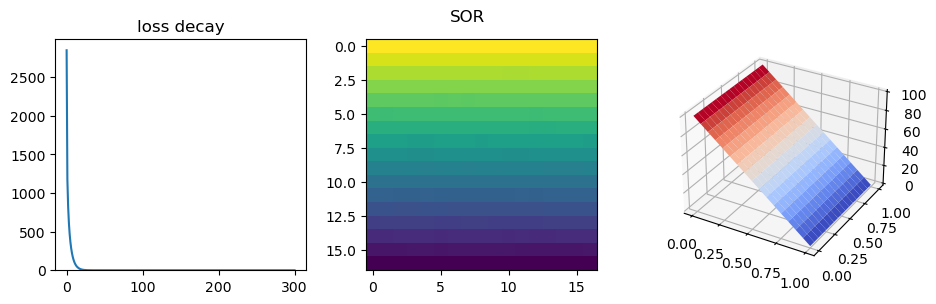

In [7]:
L = 15

def score(true, pred):
    return np.mean(np.square(true-pred))
true = get_theory_solution(L)

def plot_history(history):
    final_pot = history[-1]
    fig, axes = plt.subplots(1, 3, figsize=(11, 3))

    ax = axes[0]
    scores = [score(true, pred) for pred in history]
    ax.plot(scores)
    ax.set_ylim(bottom=0)
    ax.set_title("loss decay")

    ax = axes[1]
    ax.imshow(final_pot)

    # ax = axes[2]
    # ax.contourf(final_pot, levels=30)

    ax = axes[2]
    ax.set_axis_off()

    ax3d = fig.add_subplot(1, 3, 3, projection='3d')
    X = np.linspace(0, 1, final_pot.shape[0])
    Y = np.linspace(0, 1, final_pot.shape[1])
    X, Y = np.meshgrid(X, Y)
    ax3d.plot_surface(X, Y, final_pot.T, cmap=plt.colormaps["coolwarm"])


for algorithm, alg_name in zip([jacobi_optimize, gauss_optimize, SOR_optimize], ["jacobi", "gauss", "SOR"]):

    potential, mask = generate_map(L, mode="test")
    history = algorithm(potential, mask, 300)

    plot_history(history)

    plt.suptitle(alg_name)
    plt.show()



Lets investigate a little bit how SOR algorithm depends on `w` value

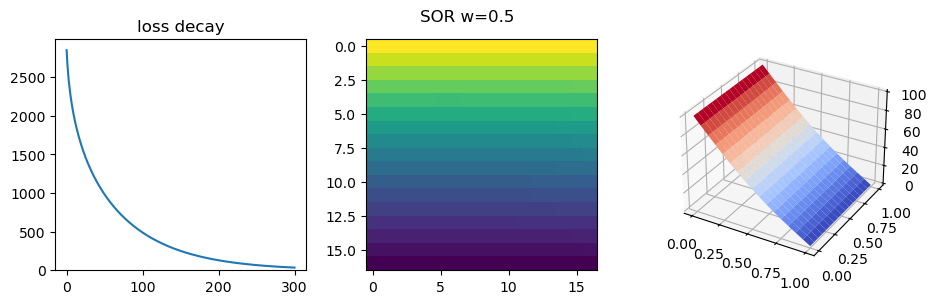

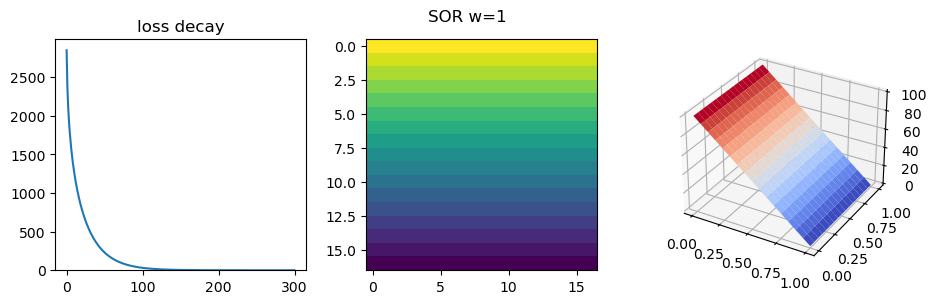

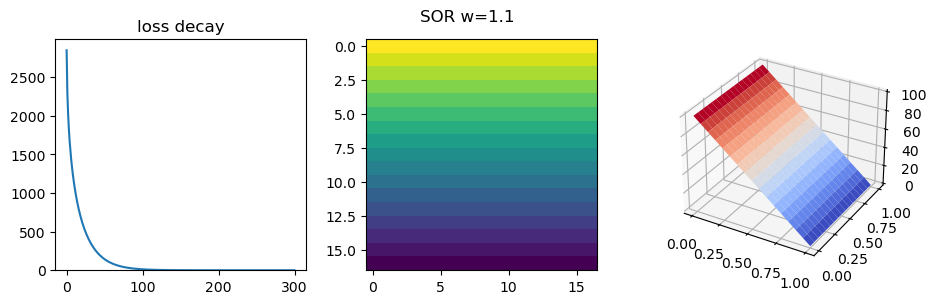

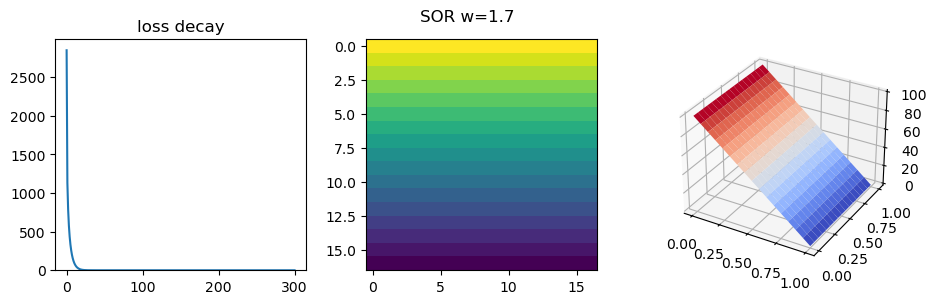

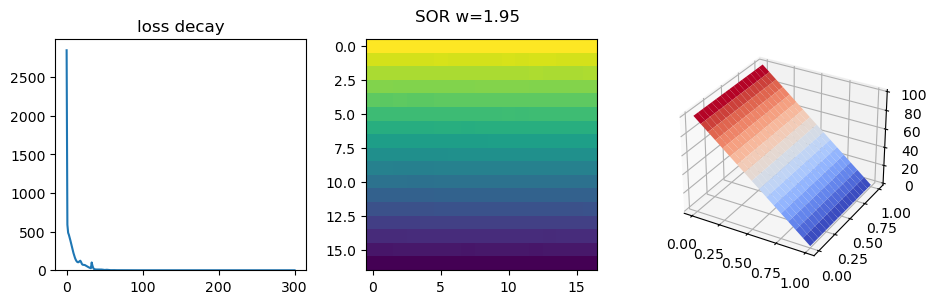

In [8]:
for w in [0.5, 1, 1.1, 1.7, 1.95]:


    algorithm, alg_name = (SOR_optimize, "SOR")


    potential, mask = generate_map(L, mode="test")
    history = algorithm(potential, mask, 300, w=w)

    plot_history(history)

    plt.suptitle(alg_name + f" w={w}")
    plt.show()


For w < 1 as expected it converges slower, w=1 is exactly gauss method, and for w > 1.02 it diverges. 

Value, that is believed to be the optimal one

$w = \frac{2}{1+\frac{\pi}{L}} \approx 1.7$

In [9]:
2/(1+np.pi/17)

1.6880492314961129

attempt to implement SOR based on Jacobi algorithm instead of Gauss

In [10]:
def SOR_optimize(potential: np.ndarray, mask: np.ndarray, max_steps, w=None):
    if w is None:
        w = 2/(1+np.pi/potential.shape[0])

    history = [potential]
    for _ in range(max_steps):
        prev = history[-1]
        new = np.zeros_like(prev)
        for i in range(prev.shape[0]):
            for j in range(prev.shape[1]):
                if mask[i, j]: # update potential
                    values_near = []
                    for i_, j_ in [(i-1, j), (i, j-1), (i+1, j), (i, j+1)]: # not updated values from previous step
                        if 0 <= i_ < prev.shape[0] and 0 <= j_ < prev.shape[1]:
                            values_near.append(prev[i_, j_])

                    new[i, j] = w*np.mean(values_near) + (1-w)*prev[i, j]
                else:   # fixed potential
                    new[i, j] = prev[i, j]
        history.append(new)

    return history

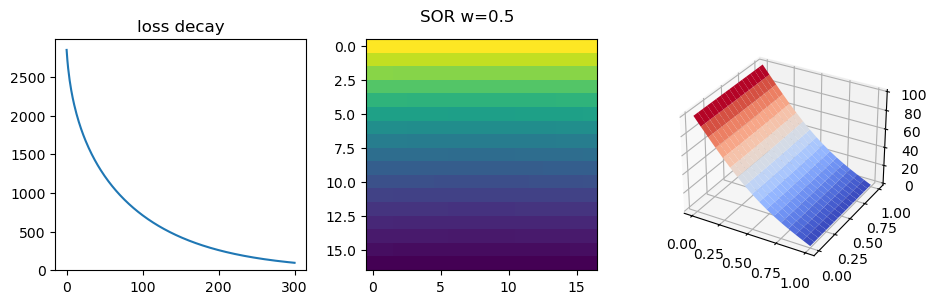

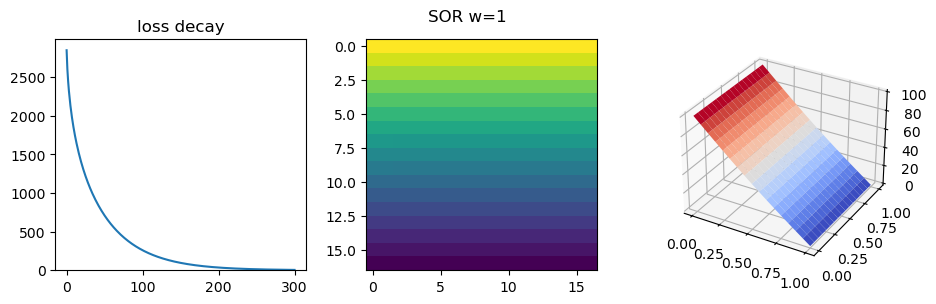

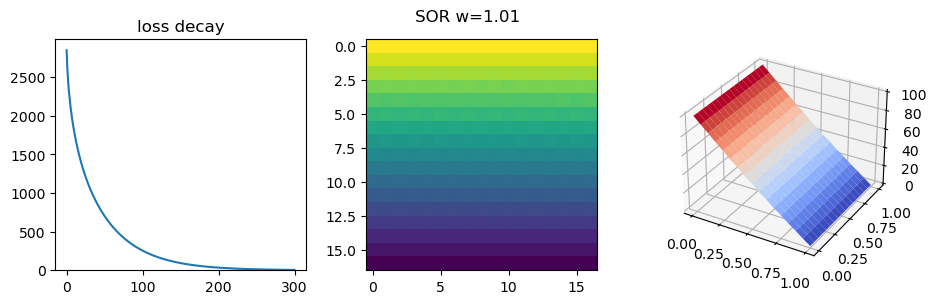

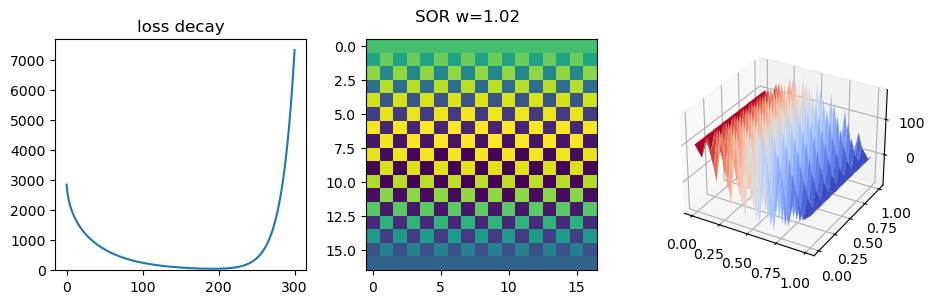

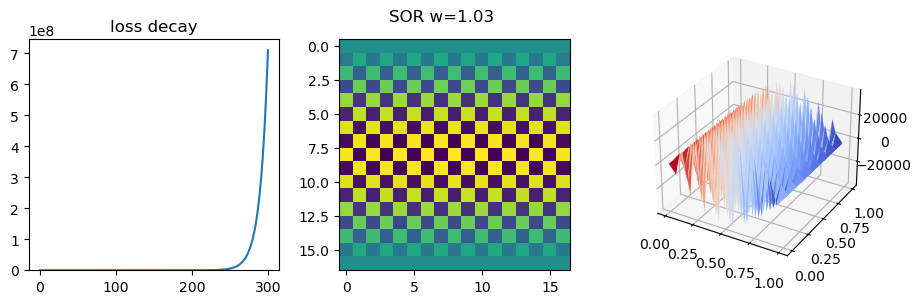

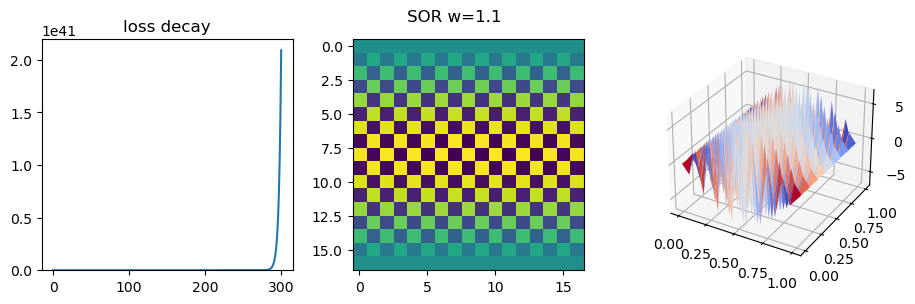

In [11]:
for w in [0.5, 1, 1.01, 1.02, 1.03, 1.1]:


    algorithm, alg_name = (SOR_optimize, "SOR")


    potential, mask = generate_map(L, mode="test")
    history = algorithm(potential, mask, 300, w=w)

    plot_history(history)

    plt.suptitle(alg_name + f" w={w}")
    plt.show()


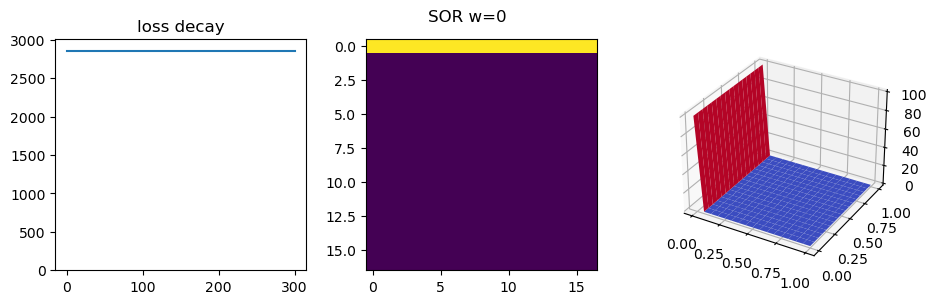

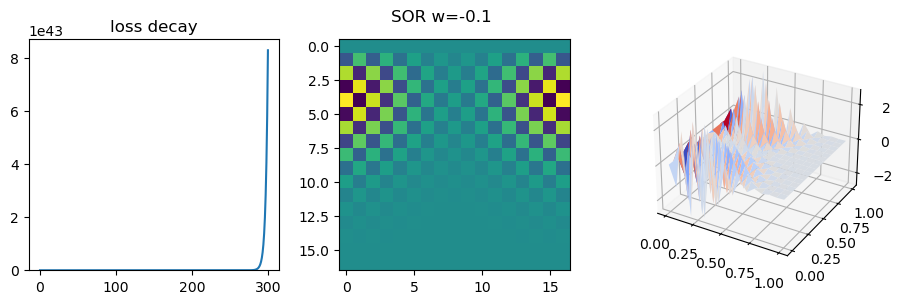

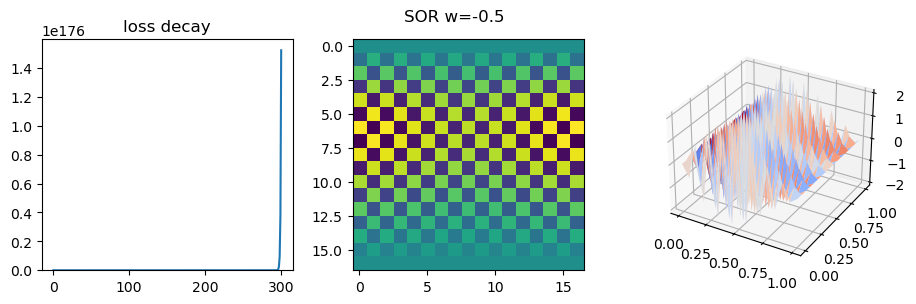

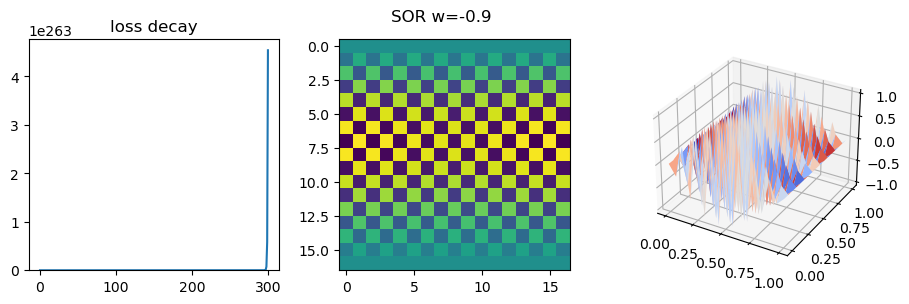

In [12]:
for w in [0, -0.1, -0.5, -0.9]:


    algorithm, alg_name = (SOR_optimize, "SOR")


    potential, mask = generate_map(L, mode="test")
    history = algorithm(potential, mask, 300, w=w)

    plot_history(history)

    plt.suptitle(alg_name + f" w={w}")
    plt.show()


Try different $L$-s

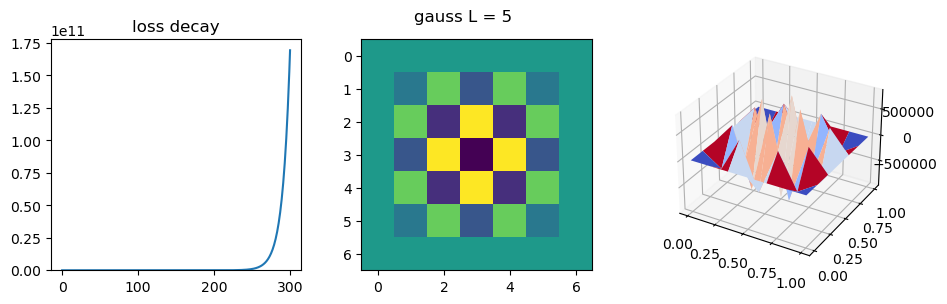

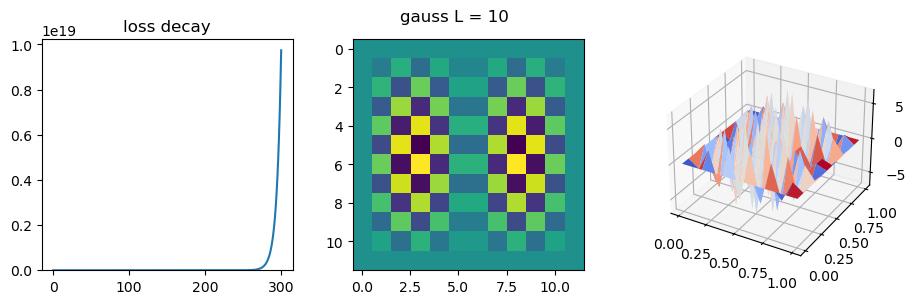

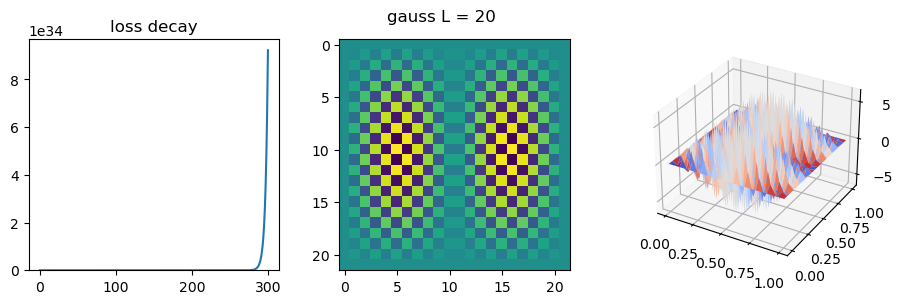

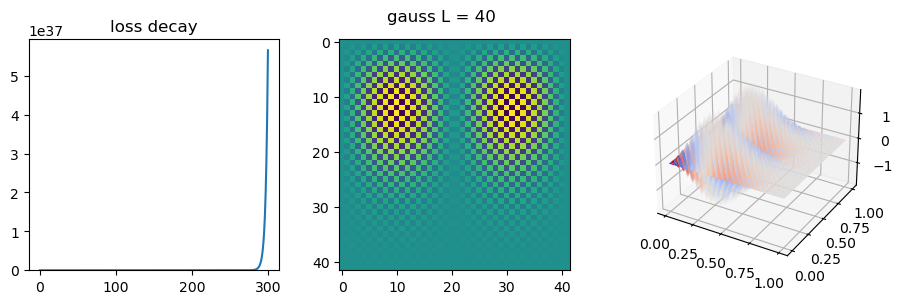

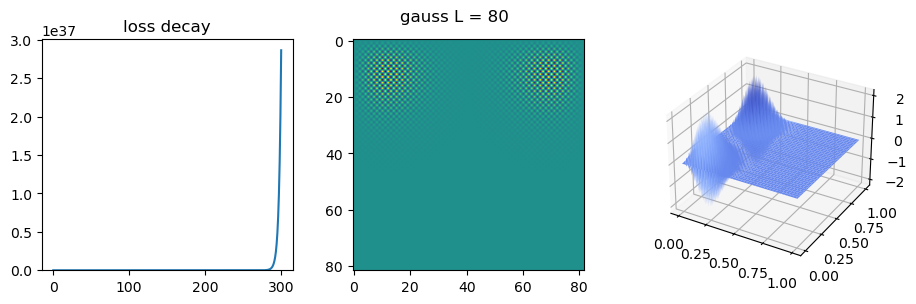

In [13]:
Ls = [5, 10, 20, 40, 80]
h_hists = []
for L in Ls:
    true = get_theory_solution(L)
    for algorithm, alg_name in zip([SOR_optimize], ["gauss"]):

        potential, mask = generate_map(L, mode="target")
        history = algorithm(potential, mask, 300, w=1.1)
        h_hists.append(history)
        plot_history(history)

        plt.suptitle(alg_name + f" L = {L}")
        plt.show()

so w between 0 and 1 for at least some convergence with Jacobi approach, which just gives smaller convergence speed relative to normal Jacobi. So it is not true, that Jacobi approach can be applied to SOR. algorithm diverges at values w>1.

Later I will use SOR method based on Gauss method.

In [14]:

def SOR_optimize(potential: np.ndarray, mask: np.ndarray, max_steps, w=None):
    if w is None:
        w = 2/(1+np.pi/potential.shape[0])

    history = [potential]
    for _ in range(max_steps):
        prev = history[-1]
        new = np.zeros_like(prev)
        for i in range(prev.shape[0]):
            for j in range(prev.shape[1]):
                if mask[i, j]: # update potential
                    values_near = []
                    for i_, j_ in [(i-1, j), (i, j-1)]: # take updated values from updated dist
                        if 0 <= i_ < prev.shape[0] and 0 <= j_ < prev.shape[1]:
                            values_near.append(new[i_, j_])
                    for i_, j_ in [(i+1, j), (i, j+1)]: # not updated values from previous step
                        if 0 <= i_ < prev.shape[0] and 0 <= j_ < prev.shape[1]:
                            values_near.append(prev[i_, j_])

                    new[i, j] = w*np.mean(values_near) + (1-w)*prev[i, j]
                else:   # fixed potential
                    new[i, j] = prev[i, j]
        history.append(new)

    return history

## a) Inference
Run algorithms on the desired boundary conditions

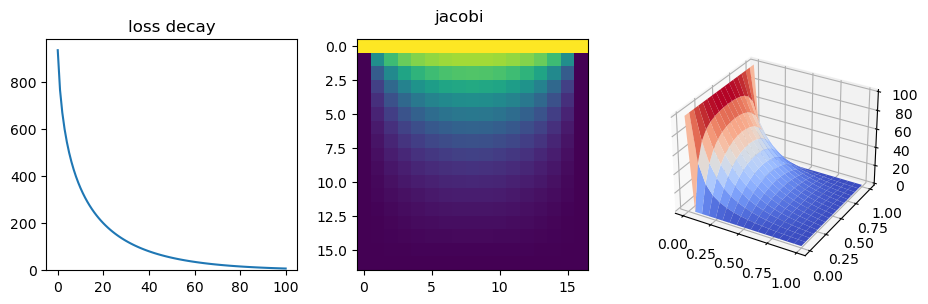

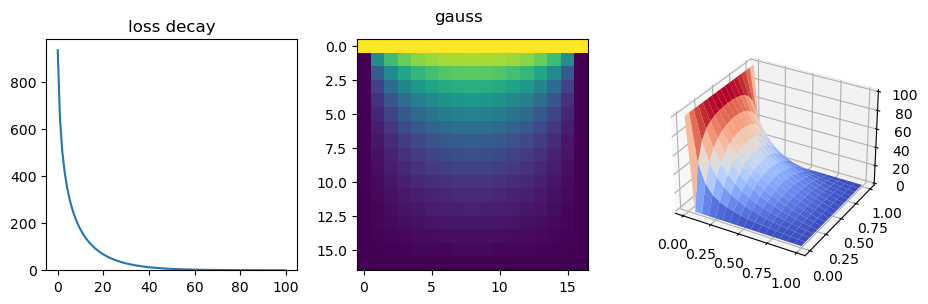

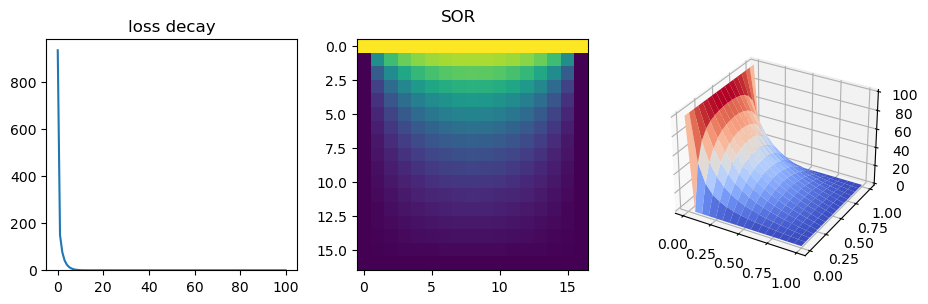

In [15]:
L = 15


potential, mask = generate_map(L, mode="target")
true = jacobi_optimize(potential, mask, 3000)[-1] # true value is assumed to be the value after far enough iteration on good working algorithm



for algorithm, alg_name in zip([jacobi_optimize, gauss_optimize, SOR_optimize], ["jacobi", "gauss", "SOR"]):

    potential, mask = generate_map(L, mode="target")

    history = algorithm(potential, mask, 100)

    plot_history(history)

    plt.suptitle(alg_name)
    plt.show()


#### b) Early stopping

I took mean value instead of sum of errors in different points, because this measure is more sensible to compare between simulations with different number of points in grids. While the sum goes to inf when number of points goes to infinity (continuous limit) 

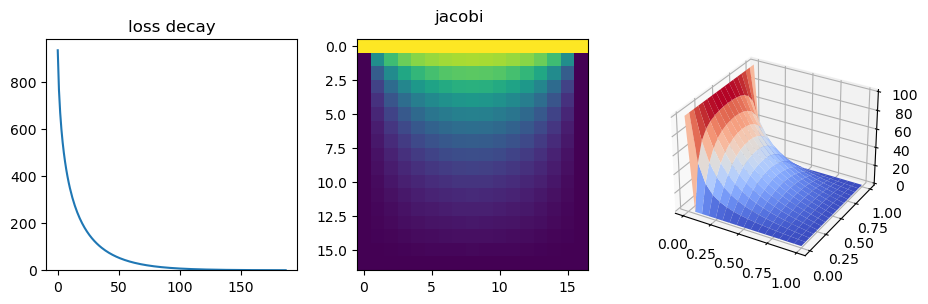

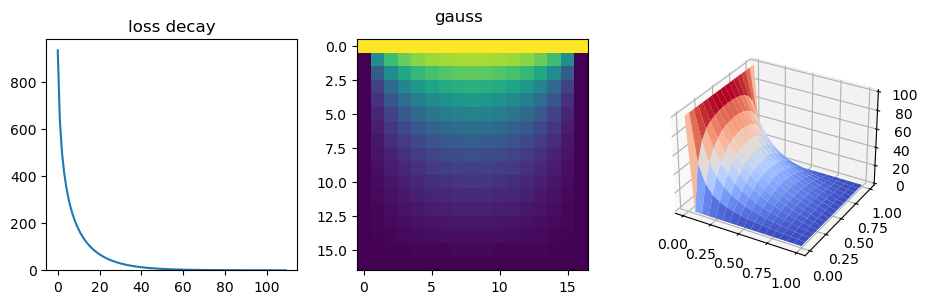

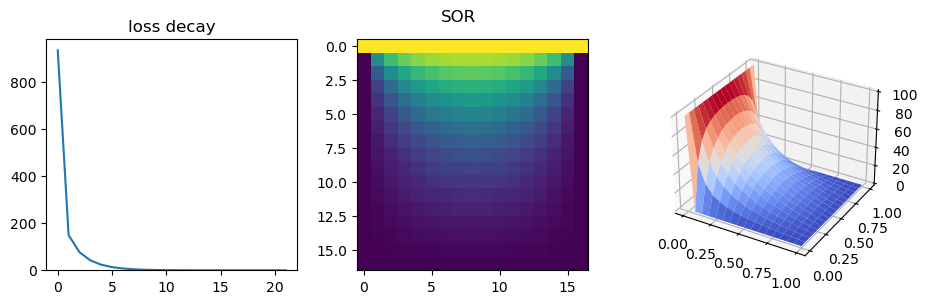

In [16]:
def early_stop_optimize(algorithm, potential, mask, max_steps, threshold=1e-4):
    history = [potential]
    for _ in range(max_steps):
        prev = history[-1]
        new = algorithm(prev, mask, 1)[-1]
        history.append(new)
        if score(prev, new) < threshold:
            break
    return history

L = 15

potential, mask = generate_map(L, mode="target")
true = jacobi_optimize(potential, mask, 3000)[-1] # true value is assumed to be the value after far enough iteration on good working algorithm



for algorithm, alg_name in zip([jacobi_optimize, gauss_optimize, SOR_optimize], ["jacobi", "gauss", "SOR"]):

    potential, mask = generate_map(L, mode="target")
    history = early_stop_optimize(algorithm, potential, mask, 400)

    plot_history(history)

    plt.suptitle(alg_name)
    plt.show()


### c) $h$ investigation

Use only gauss optimizaition for simplicity

In [17]:
def score(true, pred):
    return np.mean(np.abs(true-pred))

def plot_history(history):
    final_pot = history[-1]
    fig, axes = plt.subplots(1, 3, figsize=(11, 3))

    ax = axes[0]
    scores = [score(history[i], history[i+1]) for i in range(len(history)-1)]
    ax.plot(scores)
    ax.set_ylim(bottom=0)
    ax.set_title("potential change decay")

    ax = axes[1]
    ax.imshow(final_pot)

    # ax = axes[2]
    # ax.contourf(final_pot, levels=30)

    ax = axes[2]
    ax.set_axis_off()

    ax3d = fig.add_subplot(1, 3, 3, projection='3d')
    X = np.linspace(0, 1, final_pot.shape[0])
    Y = np.linspace(0, 1, final_pot.shape[1])
    X, Y = np.meshgrid(X, Y)
    ax3d.plot_surface(X, Y, final_pot.T, cmap=plt.colormaps["coolwarm"])


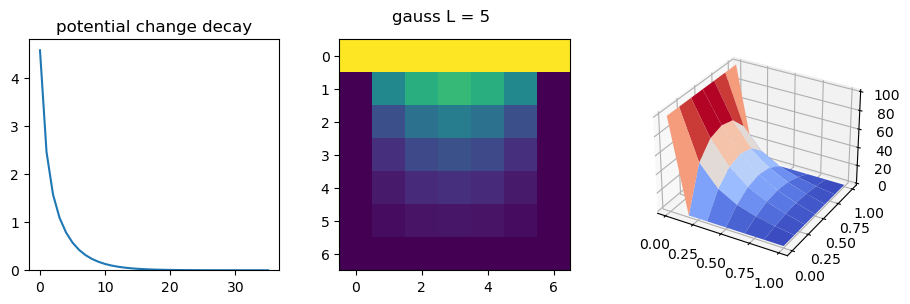

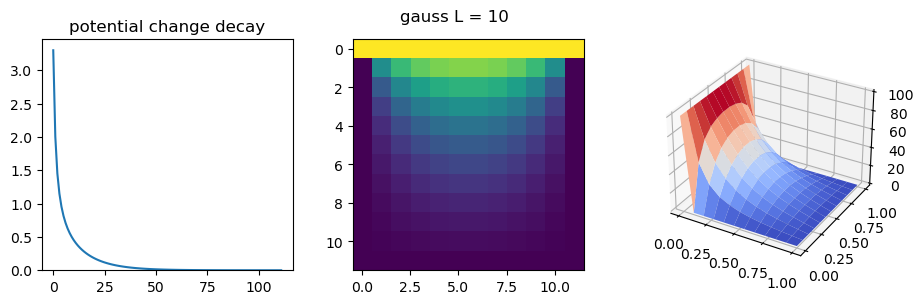

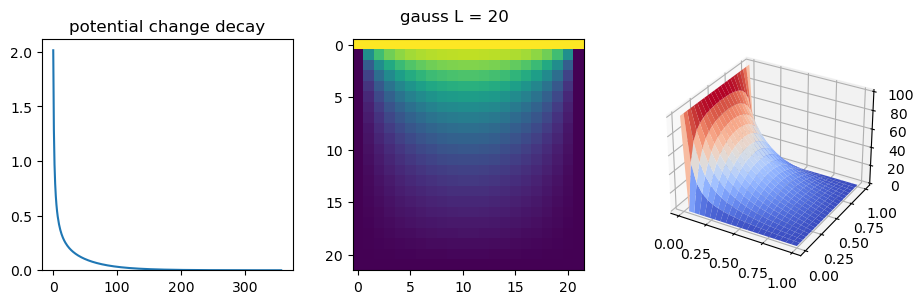

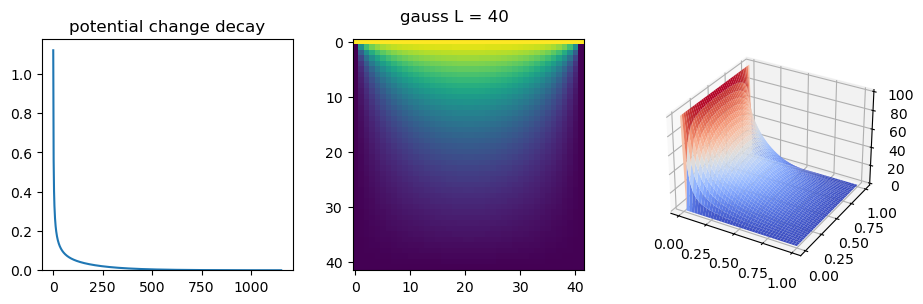

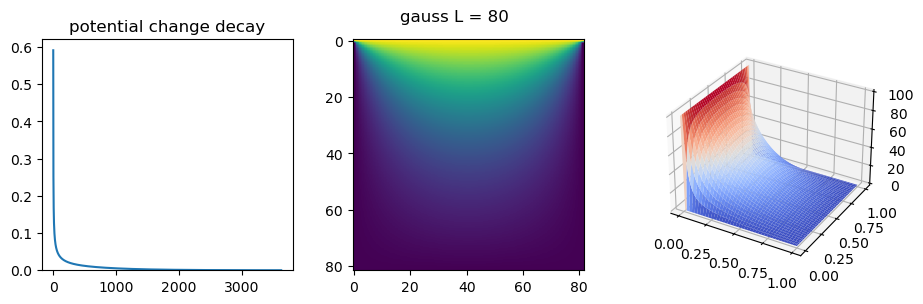

In [18]:
Ls = [5, 10, 20, 40, 80]
h_hists = []
for L in Ls:

    for algorithm, alg_name in zip([gauss_optimize], ["gauss"]):

        potential, mask = generate_map(L, mode="target")
        history = early_stop_optimize(algorithm, potential, mask, 10000)
        h_hists.append(history)
        plot_history(history)

        plt.suptitle(alg_name + f" L = {L}")
        plt.show()

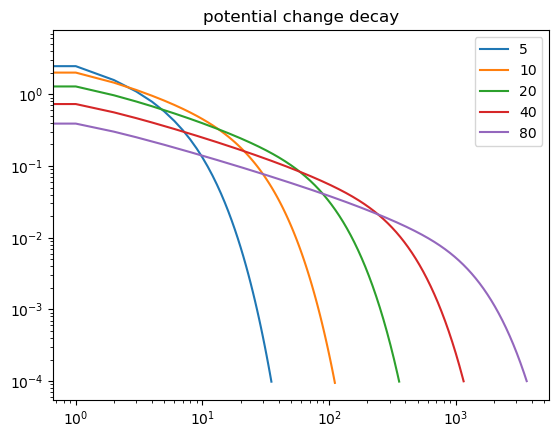

Text(0, 0.5, '# of steps to converge')

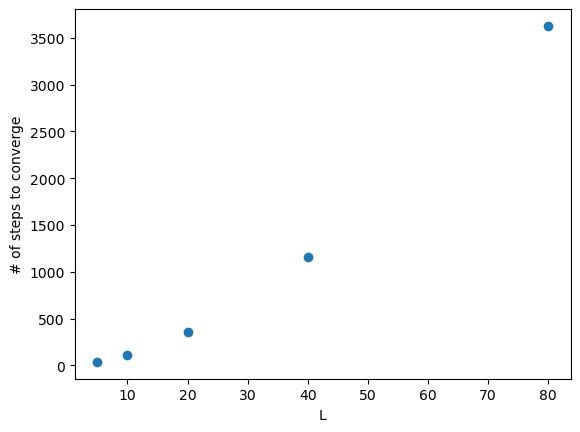

In [19]:
for L, history in zip(Ls, h_hists):
    scores = [score(history[i], history[i+1]) for i in range(len(history)-1)]
    plt.plot(scores, label=str(L))
    plt.title("potential change decay")

# plt.ylim(bottom=0, top=0.3)
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

lens = [len(history) for history in h_hists]
plt.plot(Ls, lens, "o")
plt.xlabel("L")
plt.ylabel("# of steps to converge")


The bigger the grid, the more steps it is required for the algorithm to converge, which is intuitive. More steps are required for the relaxation signal to proceed. As can be seen from the second plot, the growth of the iteration steps is superlinear. 



## d) Different algorithms convergence comparison.

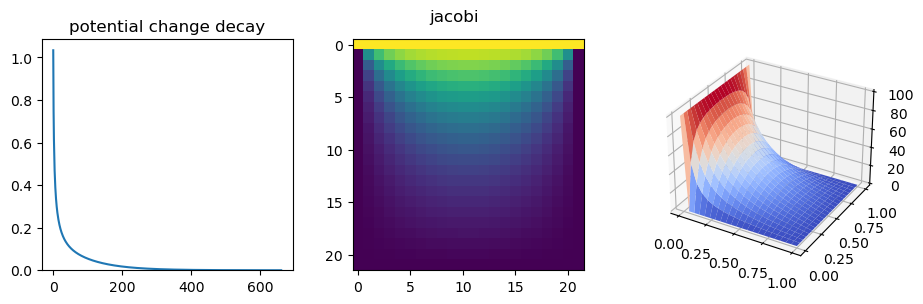

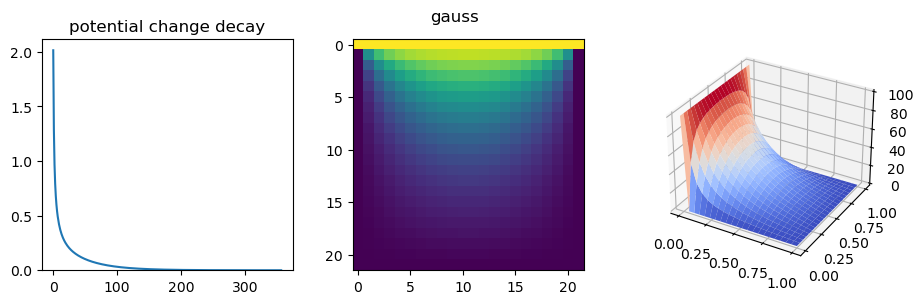

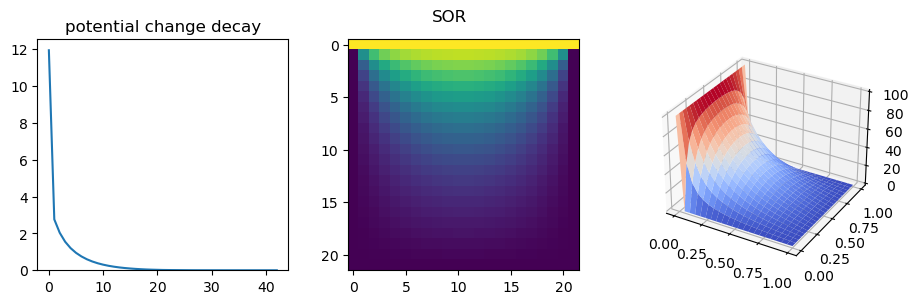

In [20]:
L = 20

h_hists = []
alg_names = []
for algorithm, alg_name in zip([jacobi_optimize, gauss_optimize, SOR_optimize], ["jacobi", "gauss", "SOR"]):

    potential, mask = generate_map(L, mode="target")
    history = early_stop_optimize(algorithm, potential, mask, 10000)
    h_hists.append(history)
    alg_names.append(alg_name)

    plot_history(history)

    plt.suptitle(alg_name)
    plt.show()

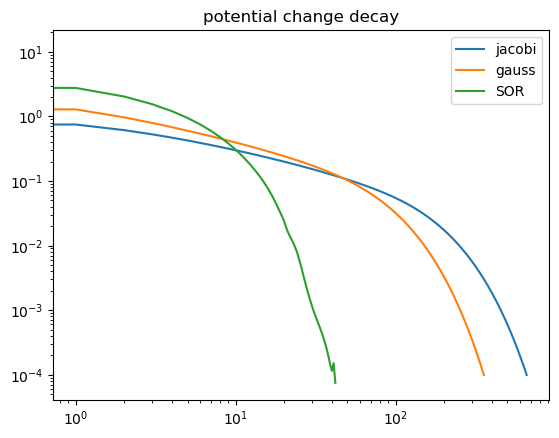

In [21]:
for alg_name, history in zip(alg_names, h_hists):
    scores = [score(history[i], history[i+1]) for i in range(len(history)-1)]
    plt.plot(scores, label=alg_name)
    plt.title("potential change decay")

plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

In [22]:
alg_steps = []
alg_names = []

Ls = [5, 10, 20, 30, 40]

for algorithm, alg_name in zip([jacobi_optimize, gauss_optimize, SOR_optimize], ["jacobi", "gauss", "SOR"]):
    alg_names.append(alg_name)
    req_steps = []

    for L in Ls:

        potential, mask = generate_map(L, mode="target")
        history = early_stop_optimize(algorithm, potential, mask, 10000)
        req_steps.append(len(history))

    alg_steps.append(req_steps)


In [23]:
from scipy.optimize import curve_fit


def err_pres_formatter(value, error):
    """Rounds value and it's error according to scientific conventions"""
    first_digit = (np.array(error/10**np.floor(np.log10(error)), dtype="int"))
    first_digit_position = np.array(np.floor(np.log10(error)), dtype="int")
    ndigits = 1
    if first_digit == 1:
        ndigits += 1
    power = np.log10(abs(value))
    if abs(power//3) >= 1:
        power = 3*int(power//3)
        value /= 10**power
        error /= 10**power
        digit_number = -first_digit_position + ndigits+power-1
        if digit_number <= 0:
            return f"({round(int(value), digit_number)} \u00B1 {round(int(error), digit_number)})$\cdot 10^{{{power}}}$"
        return f"({round(value, digit_number)} \u00B1 {round(error, digit_number)})$\cdot 10^{{{power}}}$"
    digit_number = -first_digit_position + ndigits-1
    if digit_number <= 0:
        return f"{round(int(value), digit_number)} \u00B1 {round(int(error), digit_number)}"
    return f"{round(value, digit_number)} \u00B1 {round(error, digit_number)}"


def lower_upper_limits(domain, fun, popt, pcov, nsigma=1):
    '''Вычисляет минимальные и максимальные значения функции
    при заданных парамерах и стандартных отклонениях
    в пределах nsigma*стандартное отклонение
    Возвращает:
    minA :(np.array) - массив минимальных значений
    maxA :(np.array) - массив максимальных значений'''
    err = np.sqrt(np.diag(pcov))
    corr = pcov /np.expand_dims(err, 1) / np.expand_dims(err, 0)
    deviations = np.eye(popt.size)*np.expand_dims(err, 1)
    df = np.expand_dims(fun(domain, *popt), 1) - fun(np.expand_dims(domain, 1), *(np.expand_dims(popt, 1)+np.eye(popt.size)*np.expand_dims(err, 1)))
    dfmatrixes = np.expand_dims(df, 1)*np.expand_dims(df, 2) * np.expand_dims(corr, 0)
    sigm_f = np.sqrt(np.sum(dfmatrixes, axis=(1, 2)))
    return (fun(domain, *popt)-nsigma*sigm_f, fun(domain, *popt)+nsigma*sigm_f)

def plot_approx(x, y, f, par_names_str, fun_name, yerr=None, visApproxError=True, p0=None):
    if yerr is not None:
        popt, pcov = curve_fit(f, x, y, sigma=yerr, absolute_sigma=True, p0=p0)
    else:
        popt, pcov = curve_fit(f, x, y, p0=p0)
    err = np.sqrt(np.diag(pcov))
    for v, er in zip(popt, err):
        # print(v,'+-',er)
        pass
    approx_label = f"approximation by {fun_name}"
    if (err == np.inf).any():
        print("Approximation didn't converge. Try to set initial param values p0")
    else:
        par_names = [x.split(',') for x in par_names_str.strip().split("\n") if (len(x) != 0)]
        for i in range(len(par_names)):
            t = par_names[i]
            if len(t) == 2:
                name, units = t
            else:
                name, units = *t, ''
            approx_label += f"\n{name} = {err_pres_formatter(popt[i], err[i])} {units}"
    teorPoints = 50
    indent = 0.05   # отступ по бокам от обласи экспериментальных данных
    a, b = np.min(x), np.max(x)
    X = np.linspace(a-(b-a)*indent, b+(b-a)*indent, num=teorPoints)
    plt.plot(X, f(X, *popt), 'r', label=approx_label)
    if visApproxError and (pcov != np.inf).all():
        nsigma = 2
        minA, maxA = lower_upper_limits(X, f, popt, pcov, nsigma=nsigma)
        plt.fill_between(X, minA, maxA, alpha=0.4, label=f"area of {nsigma} $\sigma$ error")


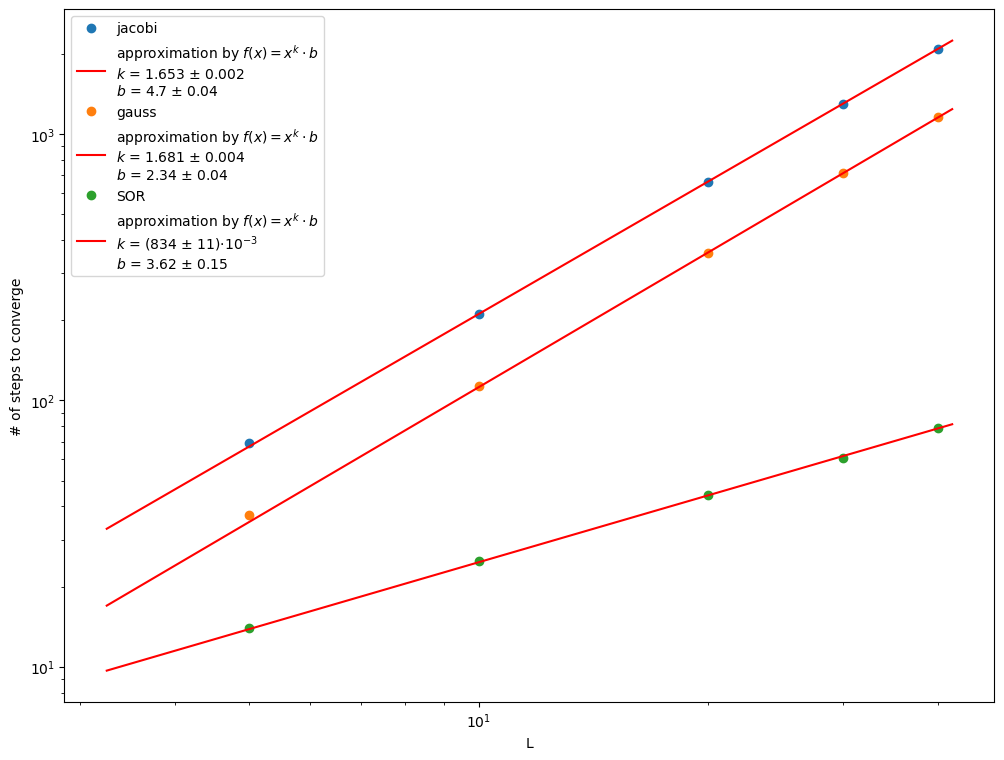

In [24]:


def line(x, k, b):
    return b*x**k

par_names_str = fr'''
$k$,
$b$,
'''
fun_name = r"$f(x) = x^k\cdot b$"

plt.figure(figsize=(12, 9))
for alg_name, req_steps in zip(alg_names, alg_steps):

    plt.plot(Ls, req_steps, "o", label=alg_name)
    plot_approx(Ls, req_steps, line, par_names_str, fun_name, visApproxError=False)
    plt.xlabel("L")
    plt.ylabel("# of steps to converge")
plt.xscale("log")
plt.yscale("log")
plt.legend()
None

## Conclusion

As can be seen from the plot, Jacobi and Gauss algorithms have the similar growth. The power of the dependence is the same power of growth, but the coefficient is approximately 2 times bigger for Jacobi.

SOR algorithm achieves better convergence speed for tested L-s and has better asymptotics. It's power is approximately 2 times smaller, than power of grown of previous algorithms.

 Do the answers agree? -> Yes, the answers agree!)

### Appendix. 
#### Random Walk method

In [25]:
import random

def RW_optimize(potential: np.ndarray, mask: np.ndarray, max_steps):
    history = [potential]

    # potentials of rw, that achieved this point.
    statistics = [[[] for j in range(potential.shape[1])] for i in range(potential.shape[0])]

    for _ in range(max_steps):
        for i in range(potential.shape[0]):
            for j in range(potential.shape[1]):
                if mask[i, j]: # free potential
                    pass
                else:   # fixed potential
                    # begin random walk
                    x, y = i, j
                    while True:
                        points_near = []
                        for i_, j_ in [(x-1, y), (x, y-1), (x+1, y), (x, y+1)]:
                            if 0 <= i_ < potential.shape[0] and 0 <= j_ < potential.shape[1]:
                                points_near.append([i_, j_])
                        next = random.choice(points_near)
                        if mask[*next]:
                            statistics[next[0]][next[1]].append(potential[i, j])
                            x, y = next
                        else:   # reached border
                            break
        new = np.array(
            [[np.sum(t)/(1e-5+len(t)) for t in row] for row in statistics]
        )
        new[~mask] = potential[~mask] # copy fixed potential values
        history.append(new)

    return history


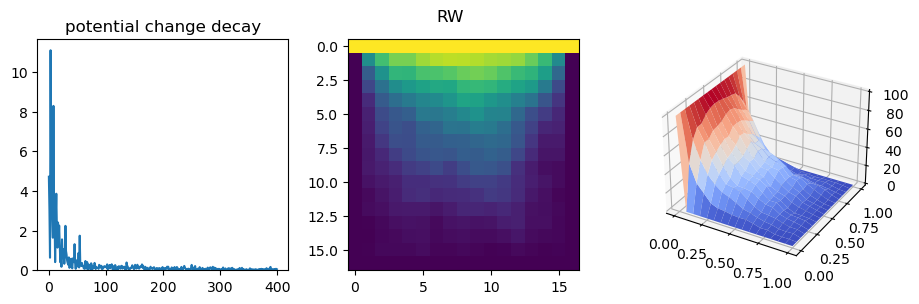

In [26]:
L = 15


algorithm, alg_name = RW_optimize, "RW"

potential, mask = generate_map(L, mode="target")
history = algorithm(potential, mask, 400)

plot_history(history)
plt.suptitle(alg_name)
plt.show()


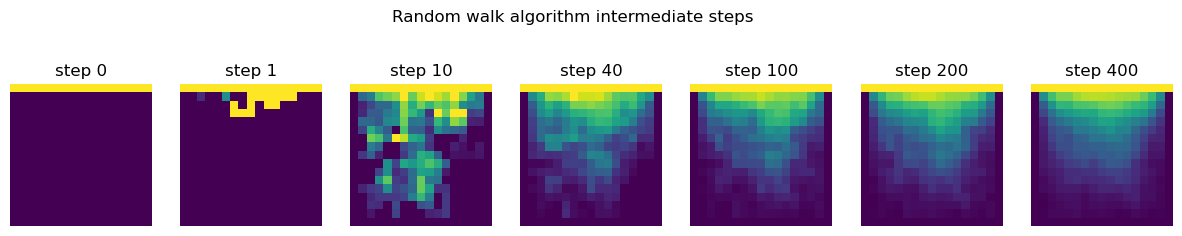

In [27]:
steps = [0, 1, 10, 40, 100, 200, 400]
images = [history[i] for i in steps]

fig, axes = plt.subplots(1, len(steps), figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(images[i])
    ax.axis('off')
    ax.set_title(f"step {steps[i]}")
plt.suptitle("Random walk algorithm intermediate steps")
None

#### Current visualization

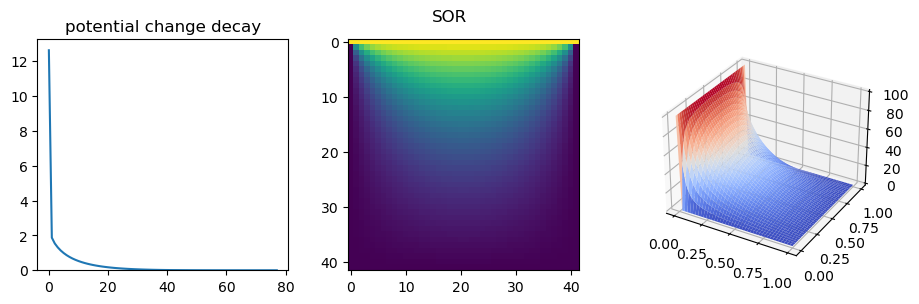

In [28]:
L = 40


algorithm, alg_name = SOR_optimize, "SOR"

potential, mask = generate_map(L, mode="target")
history = early_stop_optimize(algorithm, potential, mask, 10000)

plot_history(history)
plt.suptitle(alg_name)
plt.show()

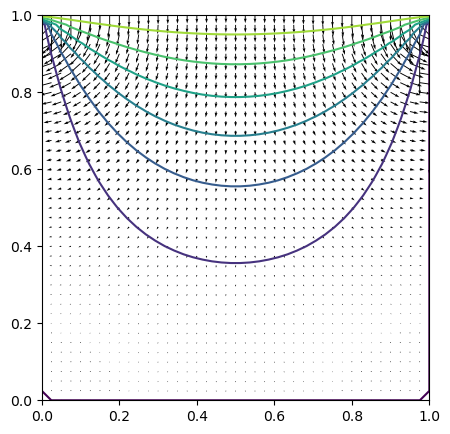

In [29]:
plt.figure(figsize=(5, 5))
final_pot = history[-1]

X = np.linspace(1, 0, potential.shape[0])
Y = np.linspace(1, 0, potential.shape[1])
X, Y = np.meshgrid(X, Y)
plt.contour(X, Y, final_pot)

X = np.linspace(1, 0, potential.shape[0]-1)
Y = np.linspace(1, 0, potential.shape[1]-1)
X, Y = np.meshgrid(X, Y)

Ey = final_pot[1:, :-1] - final_pot[:-1, :-1]
Ex = final_pot[:-1, 1:] - final_pot[:-1, :-1]
plt.quiver(X, Y, Ex, Ey)
plt.show()

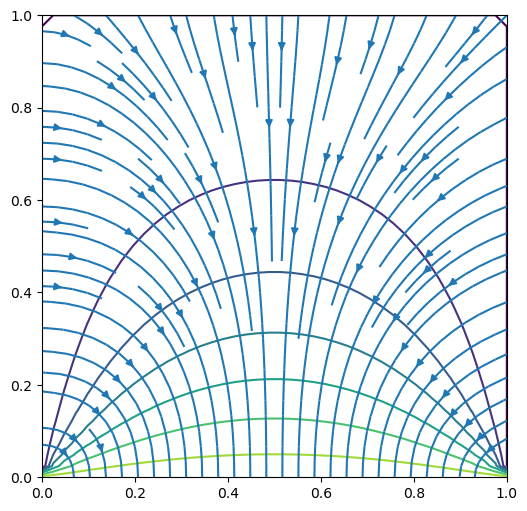

In [33]:
plt.figure(figsize=(6, 6))
X = np.linspace(0, 1, potential.shape[0])
Y = np.linspace(0, 1, potential.shape[1])
X, Y = np.meshgrid(X, Y)

plt.contour(X, Y, final_pot)

dx = 5
X = np.linspace(0, 1, potential.shape[0]-dx)
Y = np.linspace(0, 1, potential.shape[1]-dx)
X, Y = np.meshgrid(X, Y)

Ey = final_pot[dx:, :-dx] - final_pot[:-dx, :-dx]
Ex = final_pot[:-dx, dx:] - final_pot[:-dx, :-dx]
plt.streamplot(X, Y, Ex, Ey, broken_streamlines=True)
plt.show()